In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Particle Objects from Data

In [2]:
class Particle:
    def __init__(self, pos, vel, mass):
        self.pos = pos
        self.vel = vel
        self.acc = np.zeros_like(pos)
        self.mass = mass

# Density Field from Particle Objects

In [3]:
def cic_density_2d(pars, ng, h=1):
    '''
    Derive density field from particle positions and masses using CIC scheme.
    Input:
        pars: list of Particle objects
        ng: grid size
        h: grid spacing
    Output:
        rho: density field
    
    '''
    rho = np.zeros((ng, ng)) # initialize density field
    for par in pars:
        pos = par.pos
        pos_float = pos / h - 0.5   # floating point index
        pos_floor = np.floor(pos_float).astype(int) # floor of floating point index
        pos_cel = pos_floor + 1 # ceiling of floating point index
        pos_star = pos_float - pos_floor # distance from floor
        for idx_shift in [[x, y] for x in range(2) for y in range(2)]: # Density change: loop over 8 cells
            rho_idx = pos_cel - idx_shift
            rho_idx = np.where(rho_idx != ng, rho_idx, 0)
            rho[rho_idx[0], rho_idx[1]] += np.multiply.reduce(np.where(idx_shift, 1-pos_star, pos_star)) * par.mass / (h ** 3)
    return rho

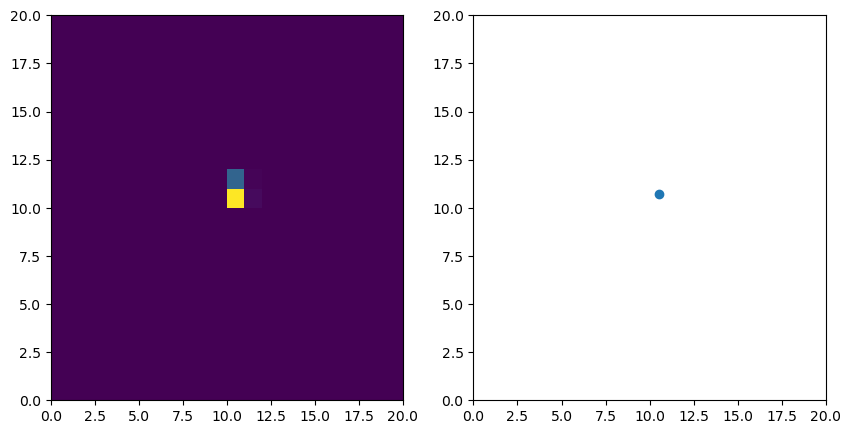

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax in axes.flatten():
    ax.set_xlim(0, ng)
    ax.set_ylim(0, ng)
axes[0].pcolormesh(np.arange(ng+1), np.arange(ng+1), rho, cmap='viridis')
# axes[1].scatter(pars_pos[:,0], pars_pos[:,1])
axes[1].scatter(pars_pos[:,1],pars_pos[:,0], )

# Gravitional Potential from Density Field

In [4]:
def grav_from_den(rho):
    '''
    Calculate gravitational potential from density field using FFT.
    Input:
        rho: density field
    Output:
        gravity_pbc: gravitational potential with periodic boundary conditions (1 cell padding for all axis)
    '''
    G = 1
    # Apply periodic boundary conditions
    rho_pbc = np.pad(rho, ((1, 1), (1, 1)), mode='wrap')

    # Calculate Fourier transform of density data with periodic boundary conditions
    density_fft = np.fft.fftn(rho_pbc, axes=(0, 1, ), norm='ortho')

    # Multiply Fourier transform by factor of 4πGρ
    gravity_fft = 4 * np.pi * G * rho_pbc * density_fft

    # Calculate inverse Fourier transform of gravity data with periodic boundary conditions
    gravity_pbc = np.real(np.fft.ifftn(gravity_fft, axes=(0, 1, ), norm='ortho'))
    return gravity_pbc

In [5]:
def grav_from_den1(rho):
    '''
    Calculate gravitational potential from density field using FFT.
    Input:
        rho: density field
    Output:
        gravity_pbc: gravitational potential with periodic boundary conditions (1 cell padding for all axis)
    '''
    G = 1

    density_fft = np.fft.fftn(rho, axes=(0, 1, ), norm='ortho')

    # Multiply Fourier transform by factor of 4πGρ
    gravity_fft = 4 * np.pi * G * rho * density_fft

    # Calculate inverse Fourier transform of gravity data with periodic boundary conditions
    gravity = np.real(np.fft.ifftn(gravity_fft, axes=(0, 1, ), norm='ortho'))
    return gravity

# Acceleration Field from Gravitational Potential

In [6]:
def cic_acc_2d(pars, ng, gravity_pbc, h=1):
    '''
    Acceleration of each particle using CIC scheme.
    Input:
        pars: list of Particle objects
        ng: grid size
        gravity_pbc: gravitational potential with periodic boundary conditions (1 cell padding for all axis)
        h: grid spacing
    Output:
        Put acceleration into Particle.acc
    '''
    acc_x_pbc, acc_y_pbc = np.gradient(gravity_pbc, 1, edge_order=1)
    acc_x, acc_y= -1 * acc_x_pbc[1:-1, 1:-1], -1 * acc_y_pbc[1:-1, 1:-1]
    
    for par in pars:
        pos = par.pos
        pos_float = pos / h - 0.5   # floating point index
        pos_floor = np.floor(pos_float).astype(int) # floor of floating point index
        pos_cel = pos_floor + 1 # ceiling of floating point index
        pos_star = pos_float - pos_floor # distance from floor
        par_acc_x, par_acc_y = 0, 0
        for idx_shift in [[x, y] for x in range(2) for y in range(2)]: # Density change: loop over 8 cells
            rho_idx = pos_cel - idx_shift
            rho_idx = np.where(rho_idx != ng, rho_idx, 0)
            par_acc_x += np.multiply.reduce(np.where(idx_shift, 1-pos_star, pos_star)) * acc_x[rho_idx[0], rho_idx[1]] * (h ** 2)
            par_acc_y += np.multiply.reduce(np.where(idx_shift, 1-pos_star, pos_star)) * acc_y[rho_idx[0], rho_idx[1]] * (h ** 2)
        par.acc = np.array([par_acc_x, par_acc_y])

In [7]:
def cic_acc_2d1(pars, ng, gravity, h=1):
    '''
    Acceleration of each particle using CIC scheme.
    Input:
        pars: list of Particle objects
        ng: grid size
        gravity_pbc: gravitational potential with periodic boundary conditions (1 cell padding for all axis)
        h: grid spacing
    Output:
        Put acceleration into Particle.acc
    '''
    acc_x_pbc, acc_y_pbc = np.gradient(gravity, 1, edge_order=1)
    acc_x, acc_y= -1 * acc_x_pbc, -1 * acc_y_pbc
    
    for par in pars:
        pos = par.pos
        pos_float = pos / h - 0.5   # floating point index
        pos_floor = np.floor(pos_float).astype(int) # floor of floating point index
        pos_cel = pos_floor + 1 # ceiling of floating point index
        pos_star = pos_float - pos_floor # distance from floor
        par_acc_x, par_acc_y = 0, 0
        for idx_shift in [[x, y] for x in range(2) for y in range(2)]: # Density change: loop over 8 cells
            rho_idx = pos_cel - idx_shift
            rho_idx = np.where(rho_idx != ng, rho_idx, 0)
            par_acc_x += np.multiply.reduce(np.where(idx_shift, 1-pos_star, pos_star)) * acc_x[rho_idx[0], rho_idx[1]] * (h ** 2)
            par_acc_y += np.multiply.reduce(np.where(idx_shift, 1-pos_star, pos_star)) * acc_y[rho_idx[0], rho_idx[1]] * (h ** 2)
        par.acc = np.array([par_acc_x, par_acc_y])

# Particle Motion using Leapfrog Integrator

In [8]:
ng = 20
num_par = 1
# pars_pos = np.random.rand(num_par,2).astype(np.float32) * ng
# pars_vel = np.random.rand(num_par,2).astype(np.float32) * 5
# pars_mass = np.random.rand(num_par).astype(np.float32)
pars_pos = np.array([[1.,1.]])
pars_vel = np.array([[3.,3.]])
pars_mass = np.random.rand(num_par).astype(np.float32)
pars_df = pd.DataFrame({'pos_x': pars_pos[:,0], 'pos_y': pars_pos[:,1],
                        'vel_x': pars_vel[:,0], 'vel_y': pars_vel[:,1],
                        'mass': pars_mass})
pars_pos = pars_df.loc[:, ['pos_x', 'pos_y']].values
pars_vel = pars_df.loc[:, ['vel_x', 'vel_y']].values
pars_mass = pars_df.loc[:, 'mass'].values
par_list = [Particle(pos, vel, mass) for pos, vel, mass in zip(pars_pos, pars_vel, pars_mass)]

In [9]:
par_list[0].pos, par_list[0].vel, par_list[0].mass, par_list[0].acc

(array([1., 1.]), array([3., 3.]), 0.1429775, array([0., 0.]))

In [53]:
rho = cic_density_2d(pars=par_list, ng=ng, h=1)
gravity_pbc = grav_from_den(rho)
gravity = grav_from_den1(rho)

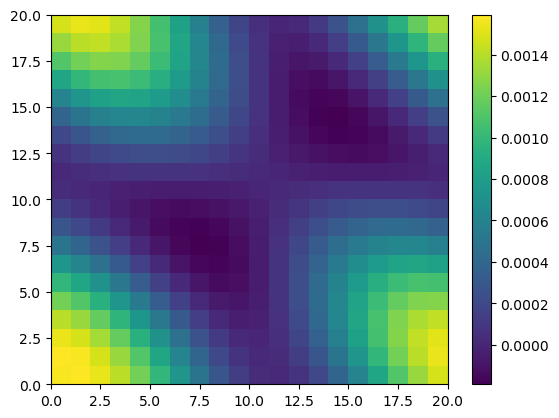

In [55]:
plt.pcolormesh(np.arange(ng+1), np.arange(ng+1), gravity, cmap='viridis')
plt.colorbar()

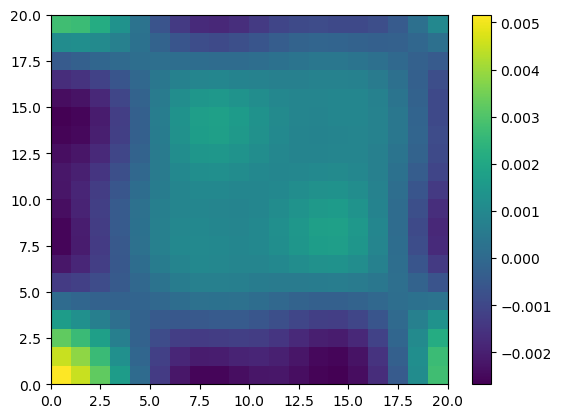

In [56]:
plt.pcolormesh(np.arange(ng+1), np.arange(ng+1), gravity_pbc[1:-1, 1:-1], cmap='viridis')
plt.colorbar()

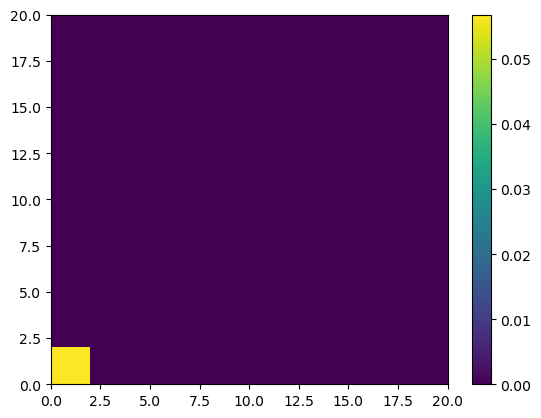

In [54]:
plt.pcolormesh(np.arange(ng+1), np.arange(ng+1), rho, cmap='viridis')
plt.colorbar()

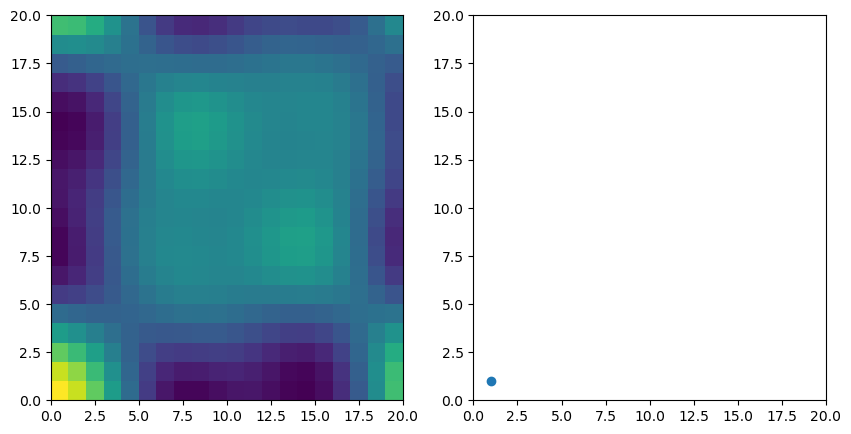

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax in axes.flatten():
    ax.set_xlim(0, ng)
    ax.set_ylim(0, ng)
# axes[0].pcolormesh(np.arange(ng+1), np.arange(ng+1), rho, cmap='viridis')
axes[0].pcolormesh(np.arange(ng+1), np.arange(ng+1), gravity_pbc[1:-1, 1:-1], cmap='viridis')
# axes[1].scatter(pars_pos[:,0], pars_pos[:,1])
axes[1].scatter(pars_pos[:,1],pars_pos[:,0], )

(array([0., 0.]), array([3., 3.]), 0.7781617, array([0., 0.]))

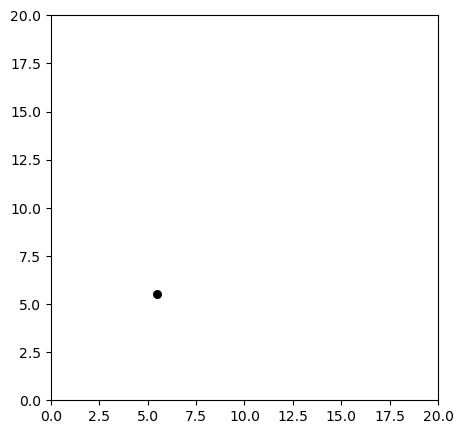

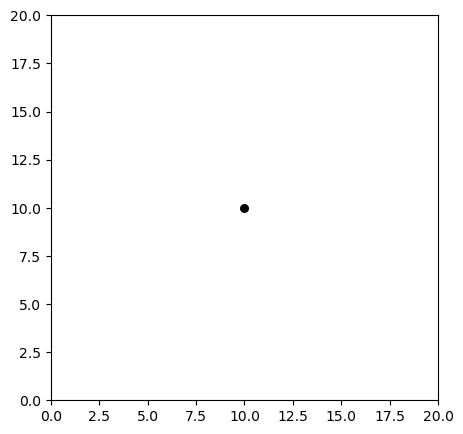

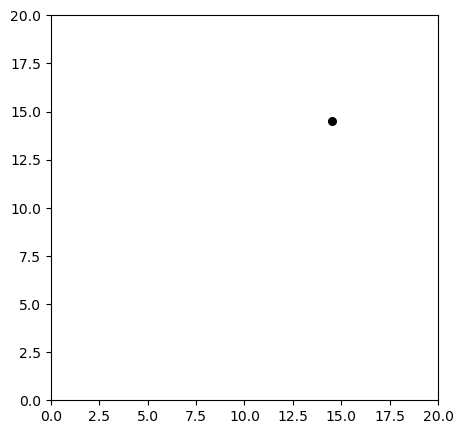

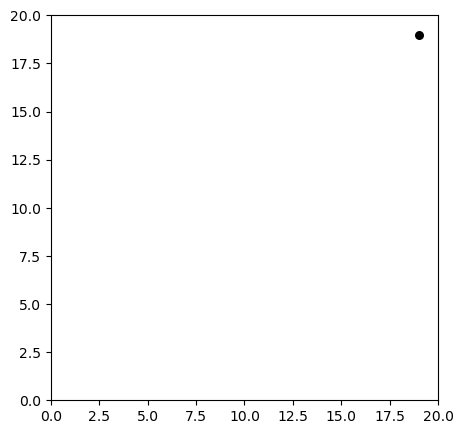

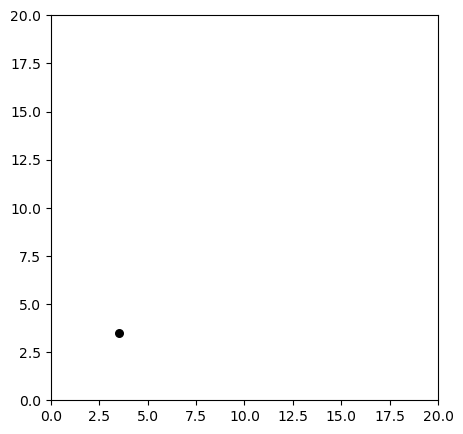

In [57]:
dt = 1
for step in range(5):
# Fitrst step: 
## 0.5 step
    for par in par_list:
        par.vel += 0.5 * par.acc * dt
        par.pos += par.vel * dt
        # Boundary condition
        for par in par_list:
            par.pos = np.where(par.pos > ng, par.pos - ng, par.pos)
            par.pos = np.where(par.pos < 0, par.pos + ng, par.pos)
    ## Update density field
    rho = cic_density_2d(pars=par_list, ng=ng, h=1)
    ## Update gravity field
    gravity_pbc = grav_from_den(rho)
    ## Update acceleration
    cic_acc_2d(pars=par_list, ng=ng, gravity_pbc=gravity_pbc, h=1)
    # Second step:
    ## 0.5 step
    for par in par_list:
        par.vel += 0.5 * par.acc * dt
        par.pos += par.vel * 0.5 * dt
        # Boundary condition
        for par in par_list:
            par.pos = np.where(par.pos > ng, par.pos - ng, par.pos)
            par.pos = np.where(par.pos < 0, par.pos + ng, par.pos)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.set_ylim(0, ng)
    for par in par_list:
        ax.scatter(par.pos[0], par.pos[1], color='k', s=30)
        ax.set_xlim(0, ng)
        ax.set_ylim(0, ng)


In [32]:
par.acc

array([0.0039906, 0.0039906])

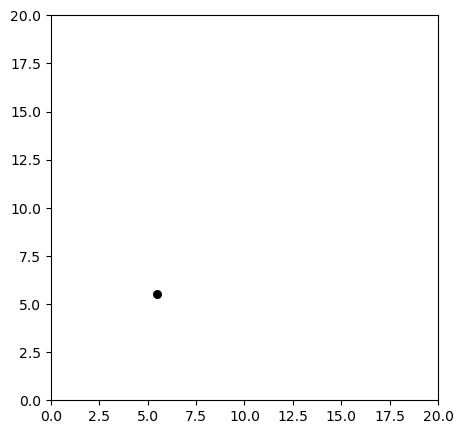

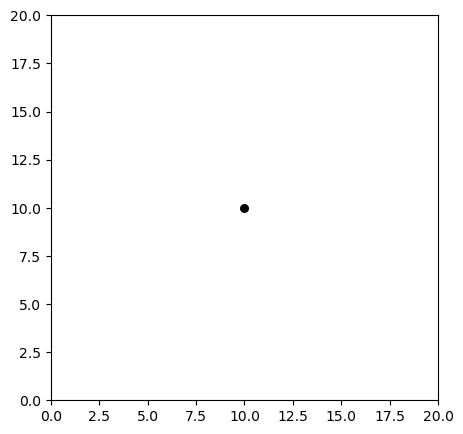

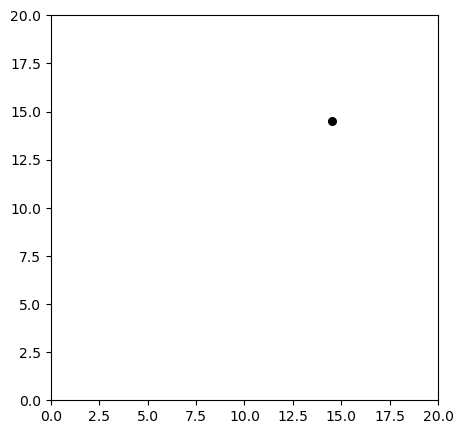

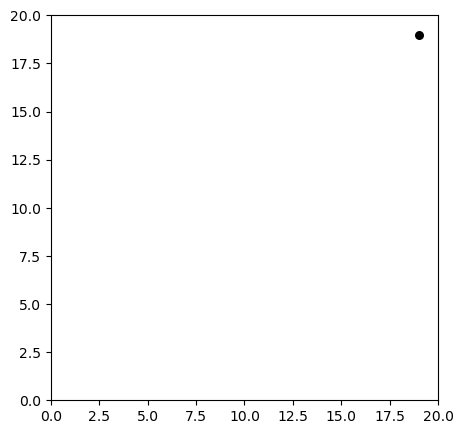

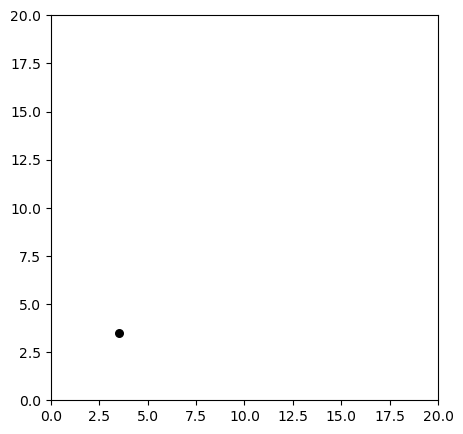

In [10]:
dt = 1
for step in range(5):
# Fitrst step: 
## 0.5 step
    for par in par_list:
        par.vel += 0.5 * par.acc * dt
        par.pos += par.vel * dt
        # Boundary condition
        for par in par_list:
            par.pos = np.where(par.pos > ng, par.pos - ng, par.pos)
            par.pos = np.where(par.pos < 0, par.pos + ng, par.pos)
    ## Update density field
    rho = cic_density_2d(pars=par_list, ng=ng, h=1)
    ## Update gravity field
    gravity = grav_from_den1(rho)
    ## Update acceleration
    cic_acc_2d1(pars=par_list, ng=ng, gravity=gravity, h=1)
    # Second step:
    ## 0.5 step
    for par in par_list:
        par.vel += 0.5 * par.acc * dt
        par.pos += par.vel * 0.5 * dt
        # Boundary condition
        for par in par_list:
            par.pos = np.where(par.pos > ng, par.pos - ng, par.pos)
            par.pos = np.where(par.pos < 0, par.pos + ng, par.pos)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.set_ylim(0, ng)
    for par in par_list:
        ax.scatter(par.pos[0], par.pos[1], color='k', s=30)
        ax.set_xlim(0, ng)
        ax.set_ylim(0, ng)


In [12]:
par.vel

array([3., 3.])

In [13]:
par.acc

array([-6.77626358e-21, -6.77626358e-21])